Importing all required packages

In [288]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Importing the CSV file

In [289]:
filtered_cardiac_interventions = pd.read_csv('filtered_cardiac_interventions.csv')
filtered_cardiac_interventions.head(5)

,Mission ID,Service Name,Latitude Permanence,Longitude Permanence,Latitude Intervention,Longitude Intervention,Vector Type,T0,T1,T2,T3,T4,T5,T6,Abandon Reason,Original File,T3_T0_difference_minutes,Dead
0,10221520047,HA UR GEEL AZ St Dimpna,51.16013,4.99975,51.20685,5.13662,MUG,2022-06-01 06:45:53,2022-06-01 06:48:30,2022-06-01 06:52:06,2022-06-01 07:04:46,NaN,NaN,2022-06-01 06:49:27,NaN,interventions_cardiac,18.883333,0
1,10221520095,BA ANTW [Kaai 606] SIHWA,51.31287,4.32425,51.24848,4.43869,AMBMUG,2022-06-01 09:28:15,2022-06-01 09:29:42,2022-06-01 09:30:28,2022-06-01 09:32:29,NaN,NaN,2022-06-01 09:59:48,Overleden,interventions_cardiac,4.233333,1
2,10221520224,HA UR ANTW Stuivenberg,51.22249,4.43629,51.28273,4.42134,AMBMUG,2022-06-01 15:11:15,2022-06-01 15:12:22,2022-06-01 15:14:47,2022-06-01 15:24:40,NaN,NaN,2022-06-01 15:43:14,Overleden,interventions_cardiac,13.416667,1
3,10221520316,FA HVP ANTW [Zuid] Antwerpen,51.20550,4.39722,51.17895,4.39024,AMBMUG,2022-06-01 19:22:57,2022-06-01 19:24:31,2022-06-01 19:28:39,2022-06-01 19:33:54,2022-06-01 20:02:54,2022-06-01 20:12:05,2022-06-01 20:28:04,NaN,interventions_cardiac,10.950000,0
4,10221520324,HA UR HERA AZ,51.18513,4.83741,51.20520,4.76586,AMBMUG,2022-06-01 19:45:13,2022-06-01 19:46:14,2022-06-01 19:50:10,2022-06-01 19:54:50,2022-06-01 20:54:40,NaN,NaN,Overleden,interventions_cardiac,9.616667,1


Let's plot the data to have a first impression!

In [ ]:
# Plotting the histogram
plt.figure(figsize=(10,6))

# Create stacked histograms for each category of 'Dead'
sns.histplot(
    data=filtered_cardiac_interventions,
    x='T3_T0_difference_minutes',
    hue='Dead',
    hue_order = [1, 0],
    multiple='stack',
    bins=300,
    palette={0: 'blue', 1: 'red'},
    kde=False
)

# Adding labels and title
plt.xlabel('Time of Intervention (minutes)')
plt.ylabel('Frequency of Events')
plt.title('Frequency of Cardiac Events by Time of Intervention')
plt.legend(title='Patient State', labels=['Alive', 'Dead'])
plt.grid(True)
plt.xlim([0, 50])

# Show the plot
plt.show()

A chi-square test is realized to check whether there is a significant association between Vector Type and the survival of the patient

In [327]:
# Create a contingency table
contingency_table = pd.crosstab(filtered_cardiac_interventions['Vector Type'], filtered_cardiac_interventions['Dead'])
print(contingency_table)
# Perform the chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print("Chi-square test results:")
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

# Check significance
alpha = 0.05
critical_value = stats.chi2.ppf(q=1-alpha, df = dof)
print(f"Critical value: {critical_value}")
if chi2 >= critical_value:
    print("There is a significant association between the vector type and the survival of the patient.")
else:
    print("There is no significant association between the vector type and the survival of the patient.")

Dead           0     1
Vector Type           
AMB          174   726
AMBAMB         1    14
AMBMUG       700  2807
AMBPIT         3    31
MUG          376   154
MUGMUG         3     6
MUGPIT        39   167
PIT           10    42
Chi-square test results:
Chi2 Statistic: 674.7471101712212
P-value: 1.9162344006653407e-141
Degrees of Freedom: 7
Expected Frequencies:
[[2.23757853e+02 6.76242147e+02]
 [3.72929754e+00 1.12707025e+01]
 [8.71909766e+02 2.63509023e+03]
 [8.45307443e+00 2.55469256e+01]
 [1.31768513e+02 3.98231487e+02]
 [2.23757853e+00 6.76242147e+00]
 [5.12156863e+01 1.54784314e+02]
 [1.29282315e+01 3.90717685e+01]]
Critical value: 14.067140449340169
There is a significant association between the vector type and the survival of the patient.


Logistic regression analysis, approach 1: Vector Type is also used as a (categorical) feature

In this case, 'Vector Type' is also taken into account and one-hot encoded

In [293]:
# One-hot encode the 'Vector Type' column
vector_type_encoded = pd.get_dummies(filtered_cardiac_interventions['Vector Type'], prefix='Vector_Type')

# Scale the numerical feature
scaler = StandardScaler()
scaled_numerical_feature = scaler.fit_transform(filtered_cardiac_interventions[['T3_T0_difference_minutes']])
scaled_numerical_feature_df = pd.DataFrame(scaled_numerical_feature, columns=['T3_T0_difference_minutes'])

# Reset indexes of both DataFrames to ensure they match
scaled_numerical_feature_df.reset_index(drop=True, inplace=True)
vector_type_encoded.reset_index(drop=True, inplace=True)

# Combine the scaled numerical feature with the one-hot encoded categorical features
X = pd.concat([scaled_numerical_feature_df, vector_type_encoded], axis=1)
y = filtered_cardiac_interventions['Dead']
X_unscaled = filtered_cardiac_interventions['T3_T0_difference_minutes']

# Training and test sets are split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(X_unscaled, y, test_size=0.2, random_state=42)

# Regression analysis is realized
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)

# Cross-validation of the model performance
scores = cross_val_score(logreg, X_test, y_test, cv=10, scoring='accuracy')
print(f'Cross-validated accuracy scores: {scores}')
print(f'Mean cross-validated accuracy: {scores.mean()}')

# Actual running of the model
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Feature names including the scaled numerical feature and the one-hot encoded features
feature_names = ['T3_T0_difference_minutes'] + vector_type_encoded.columns.tolist()

# Combine feature names with coefficients
coefficients = pd.DataFrame(logreg.coef_, columns=feature_names)

coefficients.head(5)

# Output the learned parameters
print("Coefficients:", logreg.coef_)
print("Intercept:", logreg.intercept_)


Cross-validated accuracy scores: [0.78301887 0.79047619 0.82857143 0.76190476 0.85714286 0.79047619
 0.8        0.82857143 0.8        0.82857143]
Mean cross-validated accuracy: 0.8068733153638814
Coefficients: [[ 0.09970331  0.1848775   0.65976445  0.15880695  0.66504977 -2.12130719
   0.20012511  0.16934354  0.09490138]]
Intercept: [0.13483674]


Plotting the ROC Curve and estimating its accuracy

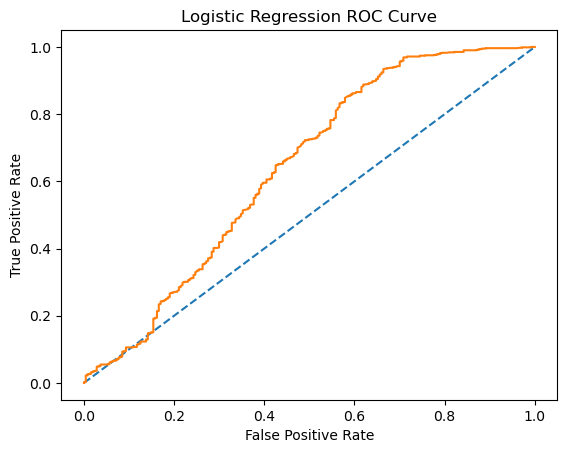

The AUC score is: 0.6387319475497009
95% confidence interval for the 95th percentile: [8.933125, 12.166666666666666]
Average intervention time after removing outliers: 10.455555555555556


In [316]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0,1], [0,1], '--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

# Calculate the Youden's J statistic
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

# Evaluate the performance at the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

print(f"The AUC score is: {roc_auc_score(y_test, y_pred_prob)}")

# Reset indexes of both DataFrames to ensure they match
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_test_unscaled.reset_index(drop=True, inplace=True)

# Create a DataFrame for the test set including original inputs and predictions
test_df = pd.DataFrame({
    'Training/Test': ['Test'] * len(X_test),
    'Unscaled_T3_T0_difference_minutes': X_test_unscaled,
    'Scaled_T3_T0_difference_minutes': X_test['T3_T0_difference_minutes'],
    'Y_True': y_test,
    'Y_Prob': y_pred_prob,
    'Y_Pred_Optimal': y_pred_optimal
})

# Filter for predicted survivors
predicted_survivors_df = test_df[test_df['Y_Pred_Optimal'] == 0]

# Extract the 'Original_T3_T0_difference_minutes' for predicted survivors
survivor_times = predicted_survivors_df['Unscaled_T3_T0_difference_minutes']

# Bootstrap to find the 95% confidence interval of the 95th percentile
def bootstrap_ci(data, percentile, n_bootstraps=1000, ci=95):
    bootstraps = np.random.choice(data, (n_bootstraps, len(data)), replace=True)
    stat = np.percentile(bootstraps, percentile, axis=1)
    lower_bound = np.percentile(stat, (100-ci)/2)
    upper_bound = np.percentile(stat, 100-(100-ci)/2)
    return lower_bound, upper_bound

ci_lower, ci_upper = bootstrap_ci(survivor_times, 50)

# Filter out the outliers
filtered_survivor_times = survivor_times[(survivor_times >= ci_lower) & (survivor_times <= ci_upper)]

# Calculate the mean of the filtered data
filtered_mean_time = np.mean(filtered_survivor_times)

print(f"95% confidence interval for the 95th percentile: [{ci_lower}, {ci_upper}]")
print(f"Average intervention time after removing outliers: {filtered_mean_time}")